In [1]:
import numpy
import math
import gpxpy
import gpxpy.gpx
import re
import matplotlib.pyplot as plt 

In [ ]:
gpx_file = open("test.gpx", "r")
gpx = gpxpy.parse(gpx_file)

track = []              #track are a list of all points(lat and long) of the gpx.    Is used for building the geometry line
for trackelmnt in gpx.tracks:       #using of the gpxpy libary
    for segment in trackelmnt.segments:
        for point in segment.points:
            track.append([point.latitude, point.longitude])
print(track[0:5])
gpx_file.close()

In [3]:
route_file = open("test.gpx", "r")        #reopening is needed here
lines = route_file.readlines()

check = False
begin = 0
end = 0
for x,line in enumerate(lines):     #iterate throu every line
    stripli = line.strip()
    if re.match(r'<rtept lat=', stripli) and check == False:        #find first point of rote-segment(used as start of route-segment insted of the acuatl strat of rout-segment because we dont need the info of the whole route --just the points)
        check = True
        begin = x
    if stripli == "</rte>":     #find end of the route segment
        end = x
    

In [ ]:
rute = lines[begin:end]     #contains the gpx text part of the route-segment
rute = [i.strip() for i in rute]
route = []          #contains the needed info of the route steps
instruction = ""

for call in rute:       #iterate throu every point of the route
    if re.match(r'<rtept lat=', call):
        koord = re.search('"(\d+.\d+)".+"(\d+.\d+)"', call)     #find the lat. and long.  from the point
        lati = koord.group(1)
        log = koord.group(2)

    if re.match(r'<name>', call):       #find the turn instruction of the point
        instruction = re.search('(?<=\>).+(?=\<)', call).group(0)
        
    if re.match(r'<gom:postInstruction>', call):
        entfernung = re.search('\d.+Kilometer|\d.+Meter', call).group(0)      # find the distance to the next point
        entfernung = entfernung.replace(" Meter", "m")
        entfernung = entfernung.replace(" Kilometer", "km")

    if re.match(r'</rtept>', call):
        route.append([lati,log,instruction,entfernung])         #detect end of one point and write everything in as one elmnt in the array
route[0][2] = "Navigation starten."         #the start point doesnt have a instruction (something like start naviation is missing) so its added manually
print(route)

In [ ]:
def calc_dist(x1,x2,y1,y2):
    lat1 = x1
    lat2 = x2
    lon1 = y1
    lon2 = y2

    R=6371000                               # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2-lat1)
    delta_lambda = math.radians(lon2-lon1)

    a = (math.sin(delta_phi / 2.0)**2) + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2*math.atan2(math.sqrt(a),math.sqrt(1 - a))
        
    #meter = R*c        #distance in meter to next koord
    return R*c

def calc_bearing(x1,x2,y1,y2):
    y = math.sin(y2 - y1) * math.cos(x2)
    x = math.cos(x1) * math.sin(x2) - math.sin(x1) * math.cos(x2) * math.cos(y2-y1)

    theta = math.atan2(y, x)
    #bearing = (theta * 180 / math.pi + 360) % 360        #bearing in degree to next koord
    return ((theta * 180 / math.pi + 360) % 360)


geom = []       #contains meter an bearing to next point of track
for i, pair in enumerate(track):            #iterate throu track koordinates and calc distance and bearing to next koord        --is used to build path geometry
    try:
        
        meter = calc_dist(pair[0], track[i+1][0], pair[1], track[i+1][1])
        bearing = calc_bearing(pair[0], track[i+1][0], pair[1], track[i+1][1])
        
        geom.append([meter,bearing])
    except:
        None

print(geom[0])

In [ ]:
data = [[0,0,False]]      #berechnen der zu plottenden datenpunkte-- jedes element in data sind die punkte zwischen denen linien gezogen werden müssen
turns = []      #enthaält die koordinaten für alle richtungsenderungen (wegpunkte)
cnt = 0
for geo in geom:
    if geo[0] != 0 and geo[1] != 0:     #wenn die werte nicht null sind, wird ein neuer datenpunkt basierend auf den bearing und distance werten von dem letzten datenpunkt ausgehend berechenet
        gk = -(math.sin(math.radians(geo[1])) * geo[0])
        ak = math.cos(math.radians(geo[1])) * geo[0]
        data.append([data[cnt][0]+gk, data[cnt][1]+ak,False])
    else:       #wenn die bewegung null ist (es liegt ein abbiegen vor), dann wird kein punkt zu data hinzugefügt
        data[cnt][2] = True     #change preset false to true if its a waypoint
        cnt -= 1
    cnt += 1

print(data[0:20])
print(turns[0:20])

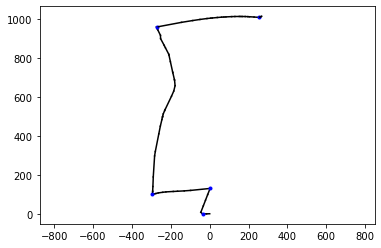

In [7]:
window_length = 75              #window size to plot th route

def connectpoints(nr):          #draw the lines between the points
    try:
        x1, x2 = data[nr][0], data[nr+1][0]
        y1, y2 = data[nr][1], data[nr+1][1]
        plt.plot([x1,x2],[y1,y2],'k-')
        if data[nr][2]:         #if this point is a waypoint then mark it as one
            plt.plot(x1,y1,".b")
    except:
        None

for i in range(window_length):        #berechent die linien aus data für die route kachel
    connectpoints(i)

plt.axis('equal')
plt.show()